**Part 1 : Miscellaneous**

In [126]:
#Installations

#!pip install emoji
#!pip install nltk
#!pip install transformers
#!pip install torch
#!pip install sentence_transformers
#!pip install textblob

In [127]:
#Environment details
import platform
import sys

# Python version
python_version = platform.python_version()

# Operating system
os_name = platform.system()
os_version = platform.version()

# Computer details
machine = platform.machine()

# Display information
print(f"Python Version: {python_version}")
print(f"Operating System: {os_name} {os_version}")
print(f"Machine: {machine}")


Python Version: 3.11.5
Operating System: Windows 10.0.22631
Machine: AMD64


In [165]:
#Imports

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import re
import emoji
import random
import string
from nltk.corpus import stopwords
import nltk
import re
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.metrics.pairwise import cosine_similarity
from sentence_transformers import SentenceTransformer
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors
from textblob import TextBlob
import itertools

import warnings
warnings.filterwarnings("ignore")

**Part 2 : Loading Dataset**

In [129]:
#Loading the dataset
path = os.getcwd()
dataset_path = path + '/dataset'
dfs = []
for i,fname in enumerate(os.listdir(dataset_path)):
    if fname.endswith('.xlsx'):
        file_path = os.path.join(dataset_path, fname)
        df = pd.read_excel(file_path)
        dfs.append(df)
df = pd.concat(dfs,ignore_index=True)
df.head()

,question,reply,replies_count,up_counts,relevance_rating
0,What is THE best question to ask on a job inte...,One that has always gone over well for me:\n\n...,7,1047,9.0
1,What is THE best question to ask on a job inte...,"When you were interviewing here, what would yo...",9,2625,6.0
2,What is THE best question to ask on a job inte...,Ask them what is the biggest problem you can s...,9,1669,7.0
3,What is THE best question to ask on a job inte...,A question that landed me a job once was:\n“If...,6,712,8.0
4,What is THE best question to ask on a job inte...,I like to ask:\n\n1. How is success measured i...,6,593,7.0


In [130]:
df.shape

(7938, 5)

In [131]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7938 entries, 0 to 7937
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   question          7938 non-null   object 
 1   reply             7937 non-null   object 
 2   replies_count     7938 non-null   int64  
 3   up_counts         7938 non-null   int64  
 4   relevance_rating  4832 non-null   float64
dtypes: float64(1), int64(2), object(2)
memory usage: 310.2+ KB


**Part 3 : Basic Preprocessing**

In [132]:
df.rename(columns={'reply': 'comment'}, inplace=True)
df.rename(columns={'up_counts': 'score'}, inplace=True)

In [133]:
#Dropping the records with no reply.
df = df.dropna(subset=['comment'])

In [134]:
#Drop duplicate records.
df.drop_duplicates(subset=['question', 'comment'], keep='first', inplace=True)

In [135]:
#Dropping the records which are deleted/removed posts.
invalid_posts = ['[deleted]','[removed]']
df = df[~df['comment'].isin(invalid_posts)]

In [136]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7571 entries, 0 to 7937
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   question          7571 non-null   object 
 1   comment           7571 non-null   object 
 2   replies_count     7571 non-null   int64  
 3   score             7571 non-null   int64  
 4   relevance_rating  4669 non-null   float64
dtypes: float64(1), int64(2), object(2)
memory usage: 354.9+ KB


In [137]:
#Cleaning the comment data.
def clean_text(text):
    #Removing the attached urls
    url_pattern = r'https?://\S+|www\.\S+'
    text = re.sub(url_pattern, '', text)
    #Replacing the \n with spaces
    text = text.replace('\n', ' ')
    #Removing the extra spaces
    text = re.sub(r'\s+', ' ', text)
    text = text.strip()
    #Removing the emojis
    text = emoji.demojize(text)
    return text
df['comment'] = df['comment'].apply(clean_text)

In [138]:
print(df.sample(n=5))

                                               question  \
1415  What do y’all think is the Best iphone 15 pro ...   
6236            What is your favourite game of all time   
3476  What is a Pokemon you love that isn't very pop...   
3885  What is a Pokemon you love that isn't very pop...   
6838            What is your favourite game of all time   

                                                comment  replies_count  score  \
1415  Nicest blue?! This blue is so boring. Sierra B...              0      3   
6236       Minecraft, Skyrim or halo reach, hard to say              0      1   
3476                             Psyduck ! I love him !              0      1   
3885                                          Donphan!!              0      1   
6838             Its literally a more fleshed out BOTW.              1      4   

      relevance_rating  
1415               NaN  
6236               6.0  
3476               NaN  
3885               NaN  
6838               NaN  


In [139]:
#Checking the target.
df['relevance_rating'].value_counts()

relevance_rating
1.0     992
6.0     840
7.0     595
8.0     587
9.0     417
10.0    357
3.0     225
5.0     214
2.0     212
4.0     156
0.0      74
Name: count, dtype: int64

There are null values and 0 as well when the considered scale is from 1-10.

In [140]:
#replacing the 0s with 1s
df['relevance_rating'] = df['relevance_rating'].replace(0.0, 1.0)
df['relevance_rating'].value_counts()

relevance_rating
1.0     1066
6.0      840
7.0      595
8.0      587
9.0      417
10.0     357
3.0      225
5.0      214
2.0      212
4.0      156
Name: count, dtype: int64

Imbalanced data based on the relevance_ratings.

**Part 4 : Visualizations**

In [141]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7571 entries, 0 to 7937
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   question          7571 non-null   object 
 1   comment           7571 non-null   object 
 2   replies_count     7571 non-null   int64  
 3   score             7571 non-null   int64  
 4   relevance_rating  4669 non-null   float64
dtypes: float64(1), int64(2), object(2)
memory usage: 354.9+ KB


In [142]:
#Shuffling the records.
df = df.sample(frac=1).reset_index(drop=True)

In [143]:
df.describe()

,replies_count,score,relevance_rating
count,7571.000000,7571.000000,4669.000000
mean,0.433100,11.222956,5.372242
std,1.451773,77.151973,3.051719
min,0.000000,-62.000000,1.000000
25%,0.000000,1.000000,2.000000
50%,0.000000,1.000000,6.000000
75%,0.000000,3.000000,8.000000
max,54.000000,2916.000000,10.000000


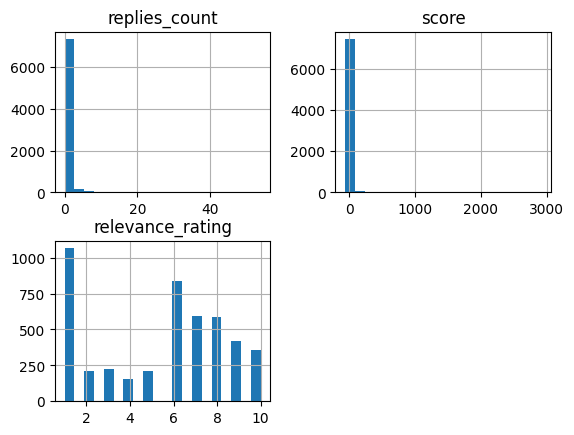

In [144]:
#Continuous values 
df.hist(bins = 20)
plt.show()

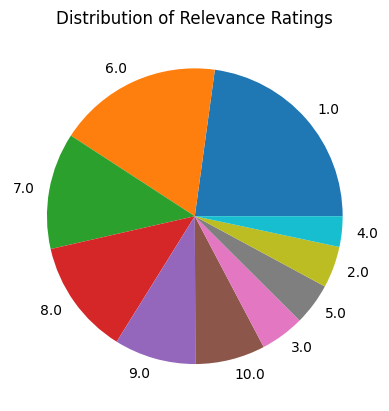

In [145]:
df['relevance_rating'].value_counts().plot.pie()
plt.title('Distribution of Relevance Ratings')
plt.ylabel('')
plt.show()

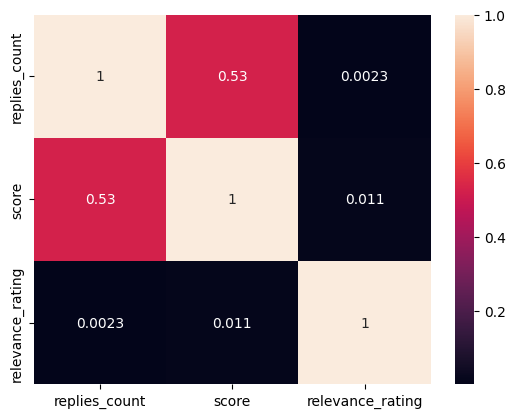

In [146]:
numeric_cols = df.select_dtypes(include=['int64', 'float64'])
sns.heatmap(numeric_cols.corr(), annot=True)
plt.show()

In [147]:
#Just for visualization:
df['question'].value_counts()

question
What is a Pokemon you love that isn't very popular or talked about?        2491
What is your favourite game of all time                                    1251
What do y’all think is the Best iphone 15 pro max color?                    898
Which cities in America is baseball more popular than football?             888
What is THE best question to ask on a job interview?                        671
Most job interviews are harder than the job itself                          344
Anyone else feel like LinkedIn is overrated to job searching?               330
What are your favorite gadgets that make life just a little bit easier?     259
What's YOUR favourite food?                                                 205
Is Youtube music better than Spotify?                                       134
Is baseball poorly designed?                                                100
Name: count, dtype: int64

In [148]:
label_encoder = LabelEncoder()
df_question_encoded = df.copy()
df_question_encoded['question'] = label_encoder.fit_transform(df_question_encoded['question'])

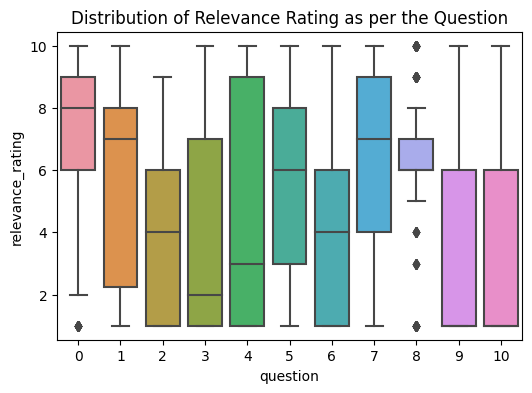

In [149]:
#Distribution of relevance_rating as per the questions.
plt.figure(figsize=(6, 4))
sns.boxplot(data=df_question_encoded, x='question', y='relevance_rating')
plt.title('Distribution of Relevance Rating as per the Question')
plt.show()

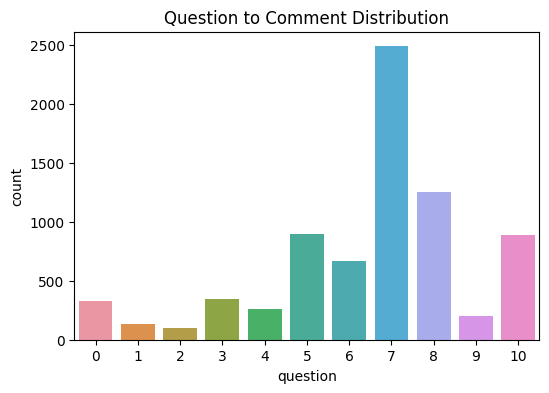

In [150]:
#Distribution of comments as per questions.
plt.figure(figsize=(6, 4))
sns.countplot(data=df_question_encoded, x='question')
plt.title('Question to Comment Distribution')
plt.show()

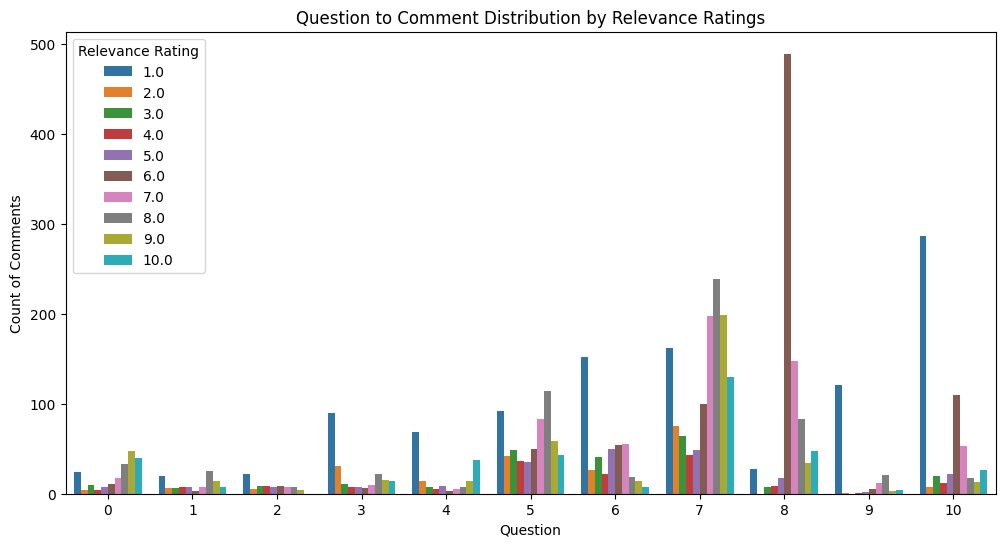

In [151]:
#Question to Comment Distribution divided by Relevance Ratings
plt.figure(figsize=(12, 6))
sns.countplot(data=df_question_encoded, x='question', hue='relevance_rating')
plt.title('Question to Comment Distribution by Relevance Ratings')
plt.xlabel('Question')
plt.ylabel('Count of Comments')
plt.legend(title='Relevance Rating')
plt.show()

**Part 5 : Getting into models**

Tried going the supervised way but giving accurate labelling to the posts on our own was kind of stiffling and we tried semi supervised way to give lables to the rest of the data by using label propogation - not very good results. <br>
Check the file : Initial working - Label propogation.ipynb in the same folder. <br>
Hence we are dabbling with unsupervised way now : 

Well ultimately what we need to do is to assign proper weights/embeddings to the words in the sentence so that the similarity metrics later used will provide good outputs. <br>
So the process flow is :
- consider an algorithm/model to assign weights to the sentences i.e, the approach is to create a complex model where the input is a string, and the output is a representation of the word or sentence (called embedding) and these embeddings should accurately represent the syntax and semantic.
- then use a similarity/distance metric among the embeddings to give a number!
- We can also use correlation coefficients i guess (lets check)

Some context for this : there are multiple ways to provide an embedding:<br>
1. Using simple similarity metrics like - cosine similiarity, Word Mover's Distance, Levenshtein distance, Hamming distance etc.
2. Using Word Embeddings (Spacy,bag-of-words,tf-idf,smooth inverse frequency)
3. Word2Vec or Doc2Vec
4. Pre-trained encoders (Transfer learning)
5. Bert embeddings
6. OpenAI
7. Siamese Networks? - needs labelling itseems
8. Semantic matching techniques ?
9. Transformers using attention mechanism

But the above points are all good for finding the syntax and similarity. How about contextual relevance then? <br>
Possible options for us to try would be : 
- Pre-trained models like bert and gpt
- Siamese networks
- Semantic matching models

I am going to use all of these and also in combinations as to pertain hybrid models.

 - <strong>Tf-Idf with Nearest neighbors</strong>

In [152]:
nltk.download('stopwords')
stop = stopwords.words('english')

def remove_punctuation(text):
    return re.sub(r'[{}]'.format(re.escape(string.punctuation)), '', text)
    
#Not using this for now!
def remove_stopwords(text):
    words = text.split()
    return ' '.join([word for word in words if word.lower() not in stop])

df['comment'] = df['comment'].apply(remove_punctuation).str.lower()
df['question'] = df['question'].apply(remove_punctuation).str.lower()
df.head()

[nltk_data] Downloading package stopwords to C:\Users\Vineetha
[nltk_data]     Maddikunta\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,question,comment,replies_count,score,relevance_rating
0,what is your favourite game of all time,when there are more than three times the numbe...,0,1,1.0
1,which cities in america is baseball more popul...,honestly i see the tide shifting back when bra...,0,3,1.0
2,what are your favorite gadgets that make life ...,portable power station keychain chapstick hold...,0,1,NaN
3,which cities in america is baseball more popul...,sacramento most of the year but right now we a...,0,1,7.0
4,what is the best question to ask on a job inte...,awesome cool story,0,-1,NaN


Lets check the basic similarities between the question and replies and among replies as well.

In [153]:
question1df = df[df['question'] == df['question'][0]]
#question1df.head()
vectorizer = TfidfVectorizer()
comment_vectors = vectorizer.fit_transform(question1df['comment'])
question_vectors = vectorizer.transform(question1df['question'])

# Compute pairwise cosine similarity between sentence vectors
cosine_similarities = cosine_similarity(comment_vectors)
cosine_similarities_qv = cosine_similarity(comment_vectors, question_vectors)

# Print cosine similarity matrix
print("Cosine Similarity Matrix:")
print(pd.DataFrame(cosine_similarities))

Cosine Similarity Matrix:
          0         1     2         3         4     5         6     7     \
0     1.000000  0.091280   0.0  0.006373  0.173050   0.0  0.019828   0.0   
1     0.091280  1.000000   0.0  0.139339  0.041170   0.0  0.063251   0.0   
2     0.000000  0.000000   1.0  0.000000  0.000000   0.0  0.000000   0.0   
3     0.006373  0.139339   0.0  1.000000  0.055767   0.0  0.013396   0.0   
4     0.173050  0.041170   0.0  0.055767  1.000000   0.0  0.028238   0.0   
...        ...       ...   ...       ...       ...   ...       ...   ...   
1246  0.000000  0.000000   0.0  0.000000  0.000000   0.0  0.000000   0.0   
1247  0.017929  0.029390   0.0  0.012114  0.000000   0.0  0.037688   0.0   
1248  0.000000  0.000000   0.0  0.000000  0.000000   0.0  0.000000   0.0   
1249  0.012127  0.034091   0.0  0.017619  0.037872   0.0  0.000000   0.0   
1250  0.000000  0.000000   0.0  0.000000  0.000000   0.0  0.000000   0.0   

          8         9     ...      1241     1242      1243   

In [154]:
def get_top_similar_pairs(cosine_similarity_matrix):
    num_records = cosine_similarity_matrix.shape[0]
    pairs = []

    # Iterate through upper triangle of similarity matrix
    for i in range(num_records):
        for j in range(i+1, num_records):
            pairs.append(((i, j), cosine_similarity_matrix[i, j]))

    # Sort pairs by similarity score in descending order
    pairs.sort(key=lambda x: x[1], reverse=True)
    return pairs

top_n = 5
top_similar_pairs = get_top_similar_pairs(cosine_similarities)
top_pairs = top_similar_pairs[:top_n]
print("Top", top_n, "similar pairs:")
for pair, similarity_score in top_pairs:
    print("Pair:", pair, "Similarity Score:", similarity_score)
    print(question1df.iloc[pair[0]]['comment'], "\nand\n" , question1df.iloc[pair[1]]['comment'])
    print("--------------------------------------")

Top 5 similar pairs:
Pair: (5, 820) Similarity Score: 1.0000000000000002
chrono trigger 
and
 chrono trigger
--------------------------------------
Pair: (15, 189) Similarity Score: 1.0000000000000002
ghost of tsushima 
and
 ghost of tsushima
--------------------------------------
Pair: (15, 539) Similarity Score: 1.0000000000000002
ghost of tsushima 
and
 ghost of tsushima
--------------------------------------
Pair: (73, 774) Similarity Score: 1.0000000000000002
outer wilds 
and
 outer wilds
--------------------------------------
Pair: (102, 282) Similarity Score: 1.0000000000000002
xenoblade chronicles 2 
and
 xenoblade chronicles x
--------------------------------------


In [155]:
top_similar_pairs = get_top_similar_pairs(cosine_similarities_qv)
top_pairs = top_similar_pairs[:top_n]
print("Top", top_n, "similar pairs:")
for pair, similarity_score in top_pairs:
    print("Pair:", pair, "Similarity Score:", similarity_score)
    print(question1df.iloc[pair[0]]['comment'], "\nand\n" , question1df.iloc[pair[1]]['comment'])
    print("--------------------------------------")

Top 5 similar pairs:
Pair: (885, 886) Similarity Score: 0.45032884334431555
red dead 2 your favourite isnt it 
and
 the walking dead telltale
--------------------------------------
Pair: (885, 887) Similarity Score: 0.45032884334431555
red dead 2 your favourite isnt it 
and
 bloodborne
--------------------------------------
Pair: (885, 888) Similarity Score: 0.45032884334431555
red dead 2 your favourite isnt it 
and
 either this or titanfall 2
--------------------------------------
Pair: (885, 889) Similarity Score: 0.45032884334431555
red dead 2 your favourite isnt it 
and
 the combat i enjoyed button mashing became a non issue when you turn on auto attack it was more dynamic than the first the enemies and locations were overused no one can deny that i enjoyed the dialogue the characters and the story it really was a game that devided a lot of people
--------------------------------------
Pair: (885, 890) Similarity Score: 0.45032884334431555
red dead 2 your favourite isnt it 
and
 so

In [156]:
nn_model = NearestNeighbors(n_neighbors=6, metric='cosine', algorithm='brute')
nn_model.fit(comment_vectors.toarray())

# Query the model to find the most similar sentence to the first sentence
query_vec = vectorizer.transform([' '.join(df['question'][0])])
distances, indices = nn_model.kneighbors(query_vec.toarray(), return_distance=True)

# Print the most similar sentence
print(indices)
print("Most similar sentence to '{}'".format(df['question'][0]))
for i in indices[0]:
    print(question1df.iloc[i]['comment'])
    print("\n")

[[835 837 834 832 836 838]]
Most similar sentence to 'what is your favourite game of all time'
oh and if you get a brass shield drop from one of the many soldiers you fight in the beginning of the game it’s hands down one of the best shields in game use it you can guardcounter with it block an attack then counter attack by pressing r2 right after this will stagger almost all normal size enemies letting you get a critical on them by standing right in front of them and pressing r1 game changer


either yo kai watch 23 or smash bros ultimate


majoras mask


for honor been playing since launch in 2017 and there is still nothing else like it almost 3000 hours at this point


nier replicant


smb3




- **Latent Dirichlet Allocation (LDA) for topic modeling**

In [157]:
question1df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1251 entries, 0 to 7562
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   question          1251 non-null   object 
 1   comment           1251 non-null   object 
 2   replies_count     1251 non-null   int64  
 3   score             1251 non-null   int64  
 4   relevance_rating  863 non-null    float64
dtypes: float64(1), int64(2), object(2)
memory usage: 58.6+ KB


In [158]:
question = question1df['question'][0]
comments = question1df['comment'].to_numpy(dtype='object')

# Vectorize the corpus using TF-IDF
vectorizer2 = TfidfVectorizer()
X = vectorizer2.fit_transform([question] + comments)

# Apply Latent Dirichlet Allocation (LDA) for topic modeling
lda_model = LatentDirichletAllocation(n_components=2, random_state=42)
lda_model.fit(X)

# Transform question and comments to topic distributions
question_topic = lda_model.transform(vectorizer2.transform([question]))
comment_topics = lda_model.transform(vectorizer2.transform(comments))

# Calculate cosine similarity between question topic and comment topics
similarity_scores = cosine_similarity(question_topic, comment_topics)[0]

# Filter relevant comments based on semantic similarity
threshold = np.percentile(similarity_scores, 50)  # Adjust threshold as needed
relevant_comments = [(comment,score) for comment, score in zip(comments, similarity_scores)]
relevant_comments = sorted(relevant_comments, key=lambda x: x[1], reverse=True)
print("Question : ",question)
print("Relevant comments:")
for comment,score in relevant_comments:
    print("-", comment,score)

Question :  what is your favourite game of all time
Relevant comments:
- minecraft or rdr2 those seem to be the games i always go back too and have phases with 0.999999898383572
- at the moment the talos principle at least in terms of theme in terms of game mechanics ksp and factorio and theres a long list of games that are basically 1 except that ive played them too many times including morrowind deus ex system shock 2 descent civilization 2 though this one is hard to play these days fallout 3 and more 0.9999997408644691
- halflife 2 2004 0.9999973467319282
- halo reach for sure 0.9999903901896157
- halo ce 0.999986578981559
- minecraft skyrim or halo reach hard to say 0.9999847714337831
- new vegas idk what it is about that bugged beauty just can’t never enjoy it and the immersion is just unmatched like shit i’ve had no other game that pulls your emotions the way new vegas does it’s just… so good 0.9999795526613875
- haven’t played zelda since ww what makes breath of the wild so good

Observations : 
1. Pretty accurate for correct ones but also classified a lot of correct ones as wrong ones.
2. Works good for small sentences but seems to be failing for longer sentences with more explanation.

- **Pre-trained models for topic modelling** (Transfer Learning)

In [159]:
model = SentenceTransformer('paraphrase-distilroberta-base-v2')
comment_embeddings = model.encode(comments)
question_embedding = model.encode(question)
num_topics = 5  
kmeans = KMeans(n_clusters=num_topics)
kmeans.fit(comment_embeddings)

# Assign each comment to a cluster
cluster_labels = kmeans.labels_

# Print comments belonging to each cluster (topic)
topics = {}
for i, comment in enumerate(comments):
    if cluster_labels[i] not in topics:
        topics[cluster_labels[i]] = []
    topics[cluster_labels[i]].append(comment)

In [160]:
filtered_data = {key: value[:4] for key, value in topics.items()}
pd.DataFrame(filtered_data)

,2,4,1,0,3
0,when there are more than three times the numbe...,botw is better as a game imo the whole world i...,zelda majoras mask,chrono trigger,sleeping dogs i fucking love everything about ...
1,mine too,i only ever played dragon age origins and koto...,horizon zerodawn and forbidden west or minecraft,good bot,final fantasy 10 for sure i have 5 copies at t...
2,uh either stick of truth or detroit become hum...,i really loved battlefield 1 i put more time i...,ghost of tsushima,witcher 3 with dlc’s,final fantasy 7 remake
3,haha yeah any other year gowr would have won b...,i jumped straight to the third having not play...,its a toss up between morrowind fallout new ve...,mass effect accompanied me the most besides th...,kingdom hearts trilogy is available on xbox


**Part 6 : Constructing our metric to calculate relevance as better as possible**

This is all good and fine but in the end how do we find which answers are with good relevance and which are not? <br>
To acheive this, we need to consider various factors like :
1. The semantic similarity of the comment to the question
2. The syntax match of comment to the question
3. The polarity of the comment
4. If we consider clusters, then the coherence factor
5. User engagement factors (like upvotes/downvotes)
6. Temporal relevance (timestamp factor)
7. diversity of perspectives
8. spam/irrelevant content detection in here as well

In [163]:
def calculate_sentiment_probabilities(text):
    analysis = TextBlob(text)
    return analysis.sentiment.p_pos, analysis.sentiment.p_neg, analysis.sentiment.p_neu

def relevance_factor(df,question_embedding,comment_embeddings,topics,model):
    comments = df['comment']
    #User engagement factors : score and reply counts
    max_score = max(df['score'])
    min_score = min(df['score'])
    normalized_scores = [(s - min_score) / (max_score - min_score) for s in df['score']]
    
    max_replies = max(df['replies_count'])
    min_replies = min(df['replies_count'])
    normalized_replies = [(count - min_replies) / (max_replies - min_replies) for count in df['replies_count']]
    
    #semantic similarity
    semantic_similarity = cosine_similarity([question_embedding], comment_embeddings)[0]
    
    #Coherence of comment to its cluster
    cluster_coherence = []
    for cluster_comments in topics.values():
        cluster_comment_embeddings = model.encode(cluster_comments)
        pairwise_similarity = cosine_similarity(cluster_comment_embeddings)
        coherence = np.mean(list(itertools.chain.from_iterable(pairwise_similarity)))  # Average of all pairwise similarities
        cluster_coherence.append(coherence)
    max_coherence = max(cluster_coherence)
    min_coherence = min(cluster_coherence)
    normalized_coherence = [(coherence - min_coherence) / (max_coherence - min_coherence) for coherence in cluster_coherence]
    
    # Sentiment polarity of each comment
    sentiment_probabilities = [calculate_sentiment_probabilities(comment) for comment in comments]
    max_sentiment = max(sentiments)
    min_sentiment = min(sentiments)
    normalized_sentiment = [(sentiment - min_sentiment) / (max_sentiment - min_sentiment) for sentiment in sentiments]

    relevance_scores = [semantic_sim + sentiment + score + replies + coherence 
                        for semantic_sim, sentiment, score, replies, coherence 
                        in zip(semantic_similarity, normalized_sentiment, normalized_scores, normalized_replies, normalized_coherence)]
    most_relevant_cluster = np.argmax(relevance_scores)
    least_relevant_cluster = np.argmin(relevance_scores)
    print(most_relevant_cluster)
    print(least_relevant_cluster)

In [166]:
relevance_factor(question1df,question_embedding,comment_embeddings,topics,model)

1
2
